# Test training and testing
Testing network and code from [Udacity Student Hub thread](https://study-hall.udacity.com/rooms/community:nd101:633452-project-300/community:thread-11891619222-594683?contextType=room) by user _Mahmoud H_ and code referenced in [Pastebin](https://pastebin.com/MBSxfqqy) in cell below (with modification of `num_workers=4` from `0`, and repackaging of dataloaders.). _Mahmoud H_ reports 7% accuracy.

CUDA is available!  Training on GPU ...


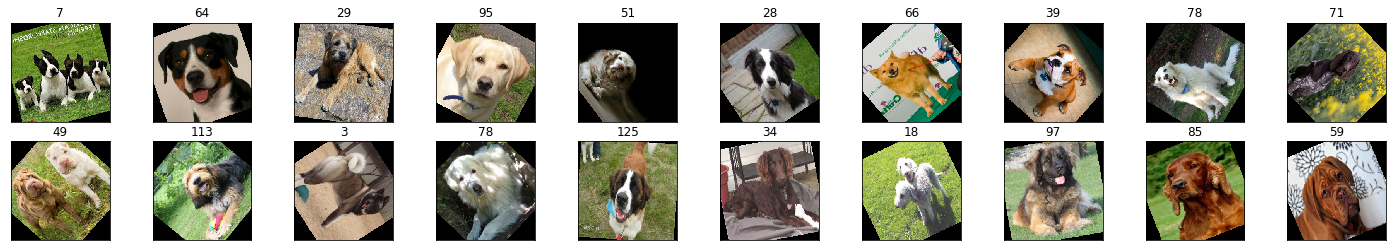

In [1]:
import os
from torchvision import datasets
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
image_size=256
rootTrain="dogImages/train/"
rootTest="dogImages/test/"
rootValid="dogImages/valid/"
transform = transforms.Compose([
                transforms.Resize((image_size,image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform2 = transforms.Compose([
                transforms.Resize((image_size,image_size)),
                transforms.RandomHorizontalFlip(p=0.99), # randomly flip and rotate
                transforms.RandomRotation(60),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_data1 = datasets.ImageFolder(root=rootTrain, transform=transform2)
#print(len(train_data1))
train_data2 = datasets.ImageFolder(root=rootTrain, transform=transform2)
train_data = train_data1 + train_data2
#print(len(train_data))

test_data = datasets.ImageFolder(root=rootTest, transform=transform)
valid_data = datasets.ImageFolder(root=rootValid, transform=transform)


# prepare data loaders (combine dataset and sampler)
loaders_scratch = {}
loaders_scratch['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders_scratch['valid'] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders_scratch['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

classes = []
for i in range(0,133):
    classes.append(str(i))

#print (classes)
#Visualize a Batch of Training Data
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# obtain one batch of training images
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])



#----------------------------------------- Arch ----------------------------------

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        #32x32x3 image
        #(n-2p+f)/s + 1
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1) 
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1) 

        self.pool = nn.MaxPool2d(2, 2) 
        self.conv1_bn = nn.BatchNorm2d(16)        
        self.conv2_bn = nn.BatchNorm2d(32)        
        self.conv3_bn = nn.BatchNorm2d(64)        

        self.fc1 = nn.Linear(32*32*64, 500)
        self.fc3 = nn.Linear(500, 133)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.conv1_bn(self.pool(F.relu(self.conv1(x))))
        x = self.conv2_bn(self.pool(F.relu(self.conv3(x))))
        x = self.conv3_bn(self.pool(F.relu(self.conv4(x))))
        x = x.view(-1, 32*32*64)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc3(x)
        return x

## complete this function
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    
    classname = m.__class__.__name__
    # for every Linear layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0,y)
        m.bias.data.fill_(0)

# create a new model with the rule-based, NORMAL weights
model_scratch = Net()
model_scratch.apply(weights_init_normal)

#print(model_scratch)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model_scratch.cuda()

## Train and test
My code below, from `dogbreed_arch_trainer.ipynb`.

`train` and `test` are essentially the same as in `dogbreed_arch_trainer.ipynb`. The problem must lie here...?

In [2]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """
    Model trainer.
    
    Args:
        n_epochs: numer of training iterations of the complete training set
        loaders: DataLoader with data for training
        model: model to train
        optimizer: backward propagation optimizer
        criterion: training criterion
        use_cuda: if cuda should be used for training
        save_path: save path for trained model
        
    Returns: trained model
    """
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU 
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Reset graditents for training batch
            optimizer.zero_grad()
            # Forward prop
            output = model(data)
            # Compute loss
            loss = criterion(output,target)
            # Compute backprop
            loss.backward()
            # Take step
            optimizer.step()
            # Train loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                output = model(data)
                loss = criterion(output, target)
                # Validation loss
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Current validation Loss: {:.6f} \tPrevious min validation Loss: {:.6f}'.format(
            valid_loss,
            valid_loss_min
            ))
            valid_loss_min = valid_loss
            print("Lowest validation score so far. Saving current model.")
        
        # Test to see training progress. Wastefull here. Only for testing. Remove below
        if (epoch % 5 == 0):
            print(' ################## \n ## Test at ' + str(epoch) + ' epochs:  ...')
            test(loaders, model, criterion, use_cuda)
            print(' ################## ')
            
    # return trained model
    return model

In [3]:
def test(loaders, model, criterion, use_cuda):
    """
    Test model accuracy and print results.
    
    Args:
        loaders: dataLoader with data for testing
        model: model to test
        criterion: test criterion for accuracy
        use_cuda: if cuda shoud be used for training
        
    Returns: None
    """
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)\n' % (
        100. * correct / total, correct, total))

## Load, train and test CNN
### Test CNN from Udacity user
CNN from [Udacity Student Hub thread](https://study-hall.udacity.com/rooms/community:nd101:633452-project-300/community:thread-11891619222-594683?contextType=room) specified in first cel. _Mahmoud H_ gets 7% accuracy.

In [4]:
import torch.optim as optim

n_epochs = 20

# Loss criterion
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model_scratch.parameters(), lr = 0.001)
# Save_location
checkpoints = 'checkpoints/model_scratch_MH_' + str(n_epochs) + '_epochs.pt'

In [5]:
model = train(n_epochs, loaders_scratch, model_scratch, optimizer, criterion, train_on_gpu, checkpoints)

Epoch: 1 	Training Loss: 5.056227 	Validation Loss: 5.234071
Current validation Loss: 5.234071 	Previous min validation Loss: inf
Lowest validation score so far. Saving current model.
Epoch: 2 	Training Loss: 4.883507 	Validation Loss: 4.894935
Current validation Loss: 4.894935 	Previous min validation Loss: 5.234071
Lowest validation score so far. Saving current model.
Epoch: 3 	Training Loss: 4.873362 	Validation Loss: 5.042928
Epoch: 4 	Training Loss: 4.875051 	Validation Loss: 4.909386
Epoch: 5 	Training Loss: 4.867083 	Validation Loss: 4.905022
 ################## 
 ## Test at 5 epochs:  ...
Test Loss: 4.881702

Test Accuracy:  0% ( 7/836)

 ################## 
Epoch: 6 	Training Loss: 4.864890 	Validation Loss: 4.871056
Current validation Loss: 4.871056 	Previous min validation Loss: 4.894935
Lowest validation score so far. Saving current model.
Epoch: 7 	Training Loss: 4.864136 	Validation Loss: 4.871534
Epoch: 8 	Training Loss: 4.864890 	Validation Loss: 4.877024
Epoch: 9 	Trai

In [6]:
model.load_state_dict(torch.load(checkpoints))
# Load and test best model (validation accuracy)
test(loaders_scratch, model_scratch, criterion, train_on_gpu)

del model, criterion, optimizer # Stops CUDA from running out of memory all the time

Test Loss: 4.855127

Test Accuracy:  1% (10/836)



 _Mahmoud H_ reports 7% accuracy. This run gave me 1% and minimal fluctuations in training and validation loss, due to randomnes in the DataLoader sampling. What am I missing with my code?

### Transfer learning - pretrained ResNet18

In [7]:
import torchvision.models as models
# Transfer learning base model architecture 
model_transfer = models.resnet18(pretrained=True)

# Freeze layers
for param in model_transfer.parameters():
    param.requires_grad = False

# Create classifier for classifying dog breed data
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 512)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout()),
    ('fc2', nn.Linear(512,133))
]))

# Replace model last layer with this classifier
model_transfer.fc = classifier.apply(weights_init_normal)

In [8]:
if train_on_gpu:
    model_transfer = model_transfer.cuda()

loaders_transfer = loaders_scratch
criterion_transfer = nn.CrossEntropyLoss()
# Train the fc parameters, other parameters are frozen
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

checkpoint = 'checkpoints/model_transfer_pre_trained_ResNet18_' + str(n_epochs) + '_epochs.pt'

# train the model
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, 
                       criterion_transfer, train_on_gpu, checkpoint)

# Load and test best model (validation accuracy)
model_transfer.load_state_dict(torch.load(checkpoint))

print(" ############### end of train ############### ")

# test
test(loaders_transfer, model_transfer, criterion_transfer, train_on_gpu)

del model_transfer # Stops CUDA from running out of memory all the time

Epoch: 1 	Training Loss: 3.770787 	Validation Loss: 1.854025
Current validation Loss: 1.854025 	Previous min validation Loss: inf
Lowest validation score so far. Saving current model.
Epoch: 2 	Training Loss: 2.889620 	Validation Loss: 1.445481
Current validation Loss: 1.445481 	Previous min validation Loss: 1.854025
Lowest validation score so far. Saving current model.
Epoch: 3 	Training Loss: 2.760072 	Validation Loss: 1.387601
Current validation Loss: 1.387601 	Previous min validation Loss: 1.445481
Lowest validation score so far. Saving current model.
Epoch: 4 	Training Loss: 2.690914 	Validation Loss: 1.293644
Current validation Loss: 1.293644 	Previous min validation Loss: 1.387601
Lowest validation score so far. Saving current model.
Epoch: 5 	Training Loss: 2.656144 	Validation Loss: 1.226491
Current validation Loss: 1.226491 	Previous min validation Loss: 1.293644
Lowest validation score so far. Saving current model.
 ################## 
 ## Test at 5 epochs:  ...
Test Loss: 1

Best checkpoint for pretrained ResNet18 gets 66% accuracy after 20 epochs, but that is approximately what it got at every test! It is obviously just stuck at some accuracy. :(

### Untrained ResNet18

In [9]:
import torchvision.models as models
# Transfer learning base model architecture 
model_untrained = models.resnet18(pretrained=False)

# Create classifier for classifying dog breed data
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 512)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout()),
    ('fc2', nn.Linear(512,133))
]))

# Replace model last layer with this classifier
model_untrained.fc = classifier
model_untrained = model_untrained.apply(weights_init_normal)

In [10]:
if train_on_gpu:
    model_untrained = model_untrained.cuda()

checkpoint = 'checkpoints/model_transfer_untrained_ResNet18_' + str(n_epochs) + '_epochs.pt'

optimizer = optim.Adam(model_untrained.parameters(), lr=0.001)

# train the model
model_untrained = train(n_epochs, loaders_transfer, model_untrained, optimizer, 
                       criterion_transfer, train_on_gpu, checkpoint)

# Load and test best model (validation accuracy)
model_untrained.load_state_dict(torch.load(checkpoint))

test(loaders_transfer, model_untrained, criterion_transfer, train_on_gpu)

del model_untrained, criterion_transfer, optimizer_transfer # Stops CUDA from running out of memory all the timeye

Epoch: 1 	Training Loss: 4.904037 	Validation Loss: 4.849888
Current validation Loss: 4.849888 	Previous min validation Loss: inf
Lowest validation score so far. Saving current model.
Epoch: 2 	Training Loss: 4.841947 	Validation Loss: 4.804462
Current validation Loss: 4.804462 	Previous min validation Loss: 4.849888
Lowest validation score so far. Saving current model.
Epoch: 3 	Training Loss: 4.811523 	Validation Loss: 4.780618
Current validation Loss: 4.780618 	Previous min validation Loss: 4.804462
Lowest validation score so far. Saving current model.
Epoch: 4 	Training Loss: 4.799823 	Validation Loss: 4.757049
Current validation Loss: 4.757049 	Previous min validation Loss: 4.780618
Lowest validation score so far. Saving current model.
Epoch: 5 	Training Loss: 4.788635 	Validation Loss: 4.761738
 ################## 
 ## Test at 5 epochs:  ...
Test Loss: 4.733941

Test Accuracy:  1% (14/836)

 ################## 
Epoch: 6 	Training Loss: 4.780823 	Validation Loss: 4.790346
Epoch: 7

Untrained ResNet18 got 3% accuracy after 20 epochs... An improvment...